# In this notebook, we will be fine-tuning a RoBERTa model for language classification on the WiLI dataset.

In [1]:
import pandas as pd
import numpy as np
from datasets import Dataset, DatasetDict, load_from_disk
from transformers import RobertaTokenizer, RobertaForSequenceClassification, TrainingArguments, Trainer
import torch
import transformers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import matplotlib.pyplot as plt
import evaluate
import time

## Loading the data and pre processing

In [2]:
#Loading the data from local storage
with open('WiLI/x_train.txt', 'r', encoding='utf-8') as f:
    x_train = f.read().splitlines()

with open('WiLI/y_train.txt', 'r', encoding='utf-8') as f:
    y_train = f.read().splitlines()

with open('WiLI/x_test.txt', 'r', encoding='utf-8') as f:
    x_test = f.read().splitlines()

with open('WiLI/y_test.txt', 'r', encoding='utf-8') as f:
    y_test = f.read().splitlines()


train_df = pd.DataFrame({'text': x_train, 'label': y_train})
test_df = pd.DataFrame({'text': x_test, 'label': y_test})

print(train_df.head())
print(test_df.head())


                                                text label
0  Klement Gottwaldi surnukeha palsameeriti ning ...   est
1  Sebes, Joseph; Pereira Thomas (1961) (på eng)....   swe
2  भारतीय स्वातन्त्र्य आन्दोलन राष्ट्रीय एवम क्षे...   mai
3  Après lo cort periòde d'establiment a Basilèa,...   oci
4  ถนนเจริญกรุง (อักษรโรมัน: Thanon Charoen Krung...   tha
                                                text label
0  Ne l fin de l seclo XIX l Japon era inda çconh...   mwl
1  Schiedam is gelegen tussen Rotterdam en Vlaard...   nld
2  ГIурусаз батальонал, гьоркьор гIарадабиги лъун...   ava
3  ರಾಜ್ಯಶಾಸ್ತ್ರದ ಪಿತಾಮಹೆ ಅರಿಸ್ಟಾಟಲ್. ರಾಜ್ಯಶಾಸ್ತ್ರ...   tcy
4  Halukum adalah kelenjar tiroid nang menonjol d...   bjn


In [3]:
# Create label mappings
unique_labels = sorted(train_df['label'].unique())
label2id = {label: idx for idx, label in enumerate(unique_labels)}
id2label = {idx: label for label, idx in label2id.items()}

# Apply mapping
train_df['labels'] = train_df['label'].map(label2id)
test_df['labels'] = test_df['label'].map(label2id)

# Quick check
print(train_df.head())
print(test_df.head())

                                                text label  labels
0  Klement Gottwaldi surnukeha palsameeriti ning ...   est      52
1  Sebes, Joseph; Pereira Thomas (1961) (på eng)....   swe     198
2  भारतीय स्वातन्त्र्य आन्दोलन राष्ट्रीय एवम क्षे...   mai     124
3  Après lo cort periòde d'establiment a Basilèa,...   oci     155
4  ถนนเจริญกรุง (อักษรโรมัน: Thanon Charoen Krung...   tha     207
                                                text label  labels
0  Ne l fin de l seclo XIX l Japon era inda çconh...   mwl     138
1  Schiedam is gelegen tussen Rotterdam en Vlaard...   nld     150
2  ГIурусаз батальонал, гьоркьор гIарадабиги лъун...   ava      10
3  ರಾಜ್ಯಶಾಸ್ತ್ರದ ಪಿತಾಮಹೆ ಅರಿಸ್ಟಾಟಲ್. ರಾಜ್ಯಶಾಸ್ತ್ರ...   tcy     202
4  Halukum adalah kelenjar tiroid nang menonjol d...   bjn      21


## Creating a tokenizer and tokenizing the data

In [4]:
# Load tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Convert Pandas DataFrames into HuggingFace Datasets
train_dataset = Dataset.from_pandas(train_df[['text', 'labels']])
test_dataset = Dataset.from_pandas(test_df[['text', 'labels']])

# Define a tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128
    )


In [5]:
# We can load tokenized dataset from memory if we have already tokenized once to save time
try:
    # Try loading pre-tokenized datasets from memory
    train_dataset = load_from_disk("./roberta_tokenized_data/train_dataset")
    test_dataset = load_from_disk("./roberta_tokenized_data/test_dataset")
    print("Loaded tokenized datasets from disk.")
except:
    print("Tokenized datasets not found. Retokenizing...")

    # Re-tokenize if loading fails
    train_dataset = train_dataset.map(tokenize_function, batched=True)
    test_dataset = test_dataset.map(tokenize_function, batched=True)

    train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
    test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

    # Save the newly tokenized datasets
    train_dataset.save_to_disk("./roberta_tokenized_data/train_dataset")
    test_dataset.save_to_disk("./roberta_tokenized_data/test_dataset")
    print("Tokenized datasets saved to disk.")


Loaded tokenized datasets from disk.


In [6]:
# Split train into train + validation
train_valid_dataset = train_dataset.train_test_split(test_size=0.1, seed=42)

train_split = train_valid_dataset['train']
valid_split = train_valid_dataset['test']

## Setting up the model and training on our training and validation data

In [7]:
num_labels = len(label2id)

# Loading the classifier
model = RobertaForSequenceClassification.from_pretrained(
    'roberta-base',
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# Initializing the training arguments
training_args = TrainingArguments(
    output_dir="./roberta-wili-checkpoints",
    eval_strategy="epoch",         
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2,
    logging_dir="./logs",
    logging_steps=50,
    report_to="none"
)


In [9]:
# Defining the evaluation metrics for the model
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    
    acc = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels, average="macro", zero_division=0)
    recall = recall_metric.compute(predictions=predictions, references=labels, average="macro")
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="macro")
    
    return {
        "accuracy": acc["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"],
    }


In [10]:
#Setting up the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_split,
    eval_dataset=valid_split,
    compute_metrics=compute_metrics
)


In [11]:
# Training the model
start = time.time()
trainer.train()
end = time.time()
print(f"Training time: {(end - start):.2f} seconds")

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.372100,0.342011,0.900085,0.901705,0.899884,0.893518
2,0.239200,0.269797,0.918979,0.925771,0.920652,0.916396
3,0.186500,0.228849,0.936426,0.942757,0.937801,0.936414
4,0.117700,0.223032,0.942894,0.944646,0.944335,0.943066
5,0.112400,0.217697,0.947319,0.949786,0.948779,0.947902


Training time: 13065.65 seconds


In [12]:
trainer.save_model("./roberta-wili-final")
tokenizer.save_pretrained("./roberta-wili-final")

('./roberta-wili-final\\tokenizer_config.json',
 './roberta-wili-final\\special_tokens_map.json',
 './roberta-wili-final\\vocab.json',
 './roberta-wili-final\\merges.txt',
 './roberta-wili-final\\added_tokens.json')

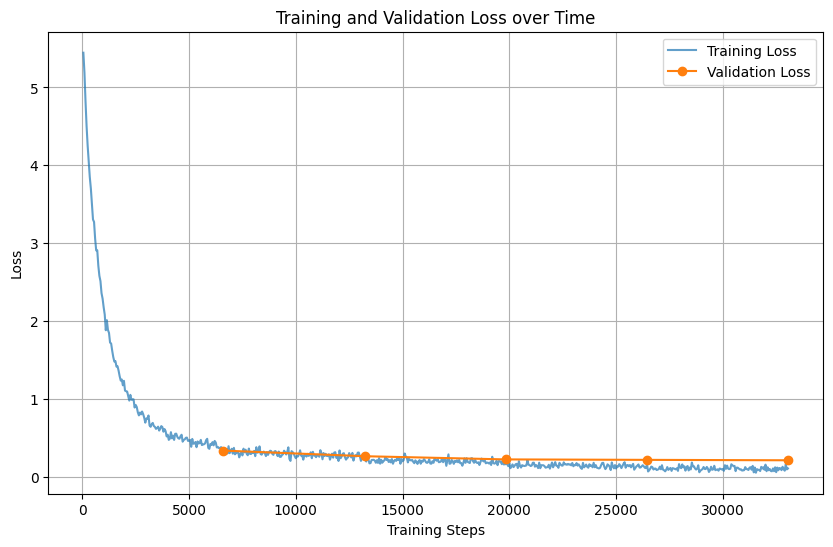

In [13]:
# Get log history
log_history = trainer.state.log_history
logs_df = pd.DataFrame(log_history)

# Filter training and evaluation logs separately
train_logs = logs_df[logs_df['loss'].notnull()]
eval_logs = logs_df[logs_df['eval_loss'].notnull()]

plt.figure(figsize=(10, 6))

plt.plot(train_logs['step'], train_logs['loss'], label='Training Loss', alpha=0.7)
plt.plot(eval_logs['step'], eval_logs['eval_loss'], label='Validation Loss', marker='o')

plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Time')
plt.legend()
plt.grid()
plt.show()


## Evaluation on the test dataset

In [14]:
print("Evaluating on test set...")

metrics = trainer.evaluate(test_dataset)

print(metrics)

Evaluating on test set...


{'eval_loss': 0.2259444296360016, 'eval_accuracy': 0.9471829787234043, 'eval_precision': 0.9488220366344561, 'eval_recall': 0.9471829787234044, 'eval_f1': 0.9470528782799411, 'eval_runtime': 795.8814, 'eval_samples_per_second': 147.635, 'eval_steps_per_second': 9.228, 'epoch': 5.0}


In [15]:

# Get predictions
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids


In [16]:

target_names = [id2label[i] for i in range(len(id2label))]


report = classification_report(labels, preds, target_names=target_names, zero_division=0)
print("RoBERTa Classification Report:")
print(report)



with open("RoBERTa_classification_report.txt", "w", encoding="utf-8") as f:
    f.write("RoBERTa Classification Report\n")
    f.write("="*60 + "\n")
    f.write(report)

accuracy = accuracy_score(labels, preds)
print(f"Overall Accuracy: {accuracy:.4f}")

RoBERTa Classification Report:
              precision    recall  f1-score   support

         ace       0.99      0.98      0.99       500
         afr       0.99      0.99      0.99       500
         als       0.90      0.94      0.92       500
         amh       1.00      0.99      0.99       500
         ang       0.97      0.96      0.97       500
         ara       0.90      0.97      0.93       500
         arg       0.98      0.98      0.98       500
         arz       0.97      0.91      0.94       500
         asm       0.96      0.97      0.97       500
         ast       0.97      0.96      0.96       500
         ava       0.88      0.82      0.85       500
         aym       0.93      0.97      0.95       500
         azb       0.99      0.97      0.98       500
         aze       0.99      0.98      0.99       500
         bak       0.98      0.96      0.97       500
         bar       0.91      0.92      0.92       500
         bcl       0.98      0.97      0.97       

In [17]:
# Compute confusion matrix
cm = confusion_matrix(labels, preds)

# Find the most confused languages

errors = cm.copy()
np.fill_diagonal(errors, 0)
confusion_sums = errors.sum(axis=1) + errors.sum(axis=0)

# Get Top 20 most confused
N = 20
top_n_indices = np.argsort(confusion_sums)[-N:]


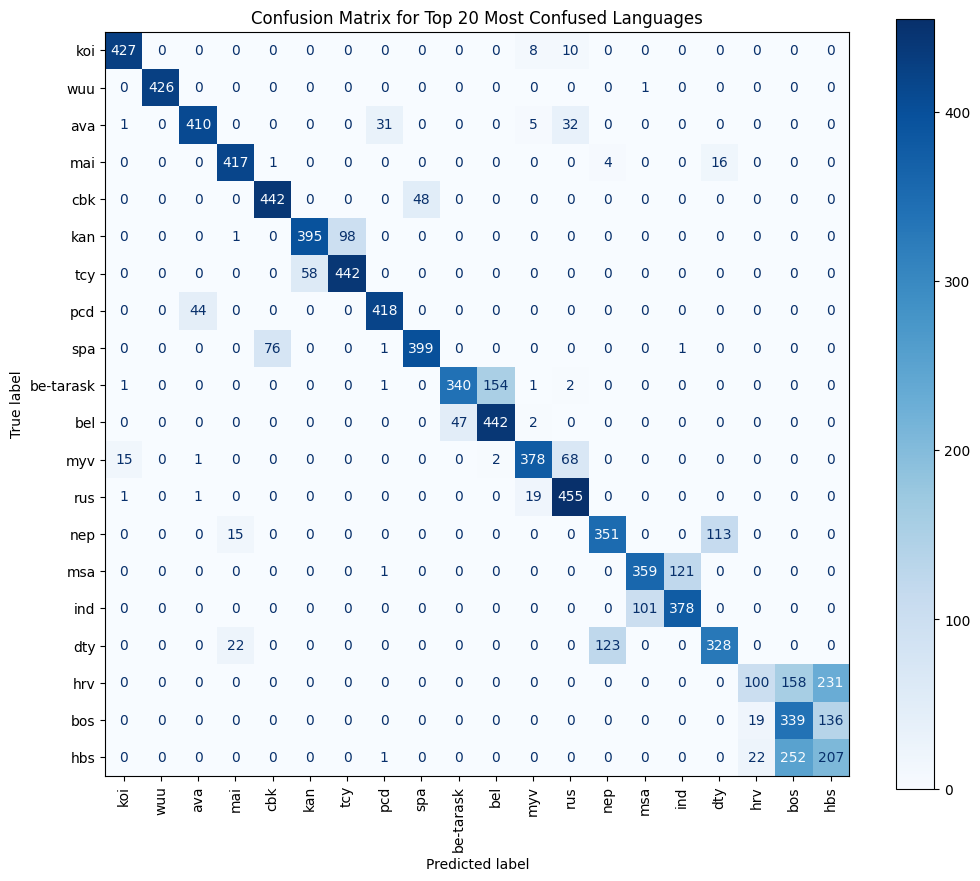

In [18]:
# Slice the confusion matrix
small_cm = cm[np.ix_(top_n_indices, top_n_indices)]

# Map indices back to labels
labels_small = [id2label[i] for i in top_n_indices]

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=small_cm, display_labels=labels_small)
disp.plot(ax=ax, xticks_rotation='vertical', values_format='.0f', cmap='Blues')
plt.title(f"Confusion Matrix for Top {N} Most Confused Languages")
plt.show()

fig.savefig("roberta_confusion_matrix_top20.png", dpi=300, bbox_inches='tight')